# Optimizing Dynamic Pricing with Reinforcement Learning

- **Deep Deterministic Policy Gradient (DDPG)** algorithm: to optimize prices and discounts, pricing decisions
- **Shapley Additive Explanations (SHAP)** : analytical tool to interpret the result to figure the impact of price, discount, and sales

## Problem Definition in RL

- Environment: The Market
- Agent: Pricing Model
- Objective: Optimize sales and profits by dynamical adjustment

## DDPG

- combines policy-based and value-based learning

### Policy-Based Learning: uses actor-network or policy function

$$ \pi (s | \theta ^ \pi) $$

given a state $s$, $\theta ^ \pi$ are the parameters of the policy

result of thte function is referred as the "action", or $a$


### Value-Based Learning: uses a critic network, Q function

$$Q(s,a| \pi^Q)$$

### Learning Process

1. Actor-Critic Architecture:
- Policy is updated by the gradient of expected return
- critic udpates value estiamtes by Bellman equation

2. Experience Replay: store $(s,a,r,s^\prime)$ in a replay buffer, random sampling these tuples.

- $s$: the initial state, $a$: action taken, $r$: reward, $s'$: the resulting state

3. Target Networks: udpated at a longer rate than the main network, 그냥 따로 저장하는 파라미터들 느낌, 극단적 변화 완화용

- $ \theta^{\pi\prime}$ , $ \theta^{Q\prime}$ are the parameters

### Benefits of DDPG

- Adaptive: Real-Time adjustments
- Fine-Tuned Decisions: Continuous action space (무수히 많은 연속적 행위 공간에서 행위 선택가능)
- Data-Driven Insights: 데이터 기반 조정?

# Code Toy Example


### 1. Initialize Environment

- $SalesPredictionEnv$: the market. price, discount, and sales as input

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.6 MB/s eta 0:00:00


In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.3 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
import shap

/usr/local/lib/python3.10/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [ ]:
class SalesPredictionEnv(gym.Env):
    def __init__(self, initial_price, initial_discount, true_sales_function):

        # gym.Env의 변수들을 상속한다

        super(SalesPredictionEnv, self).__init__()
        self.initial_price = initial_price
        self.initial_discount = initial_discount
        self.true_sales_function = true_sales_function

        # 영역을 Box라는 객체로 설정한다!
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape = (2,), dtype = np.float32)

        # Observation space: current price, discount, and predicted sales
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

        self.price = self.initial_price
        self.discount = self.initial_discount
        self.sales = self.true_sales_function(self.price, self.discount)
        self.done = False

    def reset(self, seed = None, options = None):
        super().reset(seed=seed)
        self.price = self.initial_price
        self.discount = self.initial_discount
        # 매출은 가격과 할인으로 정해진다
        self.sales = self.true_sales_function(self.price, self.discount)
        return np.array([self.price, self.discount, self.sales], dtype=np.float32), {}

    def step(self, action):
        # 행위는 가격과 할인을 조정하는 것으로 정의도니다.
        self.price += action[0]
        self.discount += action[1]

        # 조정된 가격과 할인을 통해 또 매출을 구한다
        new_sales = self.true_sales_function(self.price, self.discount)

        # 보상이 매출 차이의 음수?
        # 정해진 목표 매출, 하지만 환경이 변화!
        reward = -abs(self.sales - new_sales)
        self.sales = new_sales
        self.done = False

        return np.array([self.price, self.discount, self.sales], dtype = np.float32), reward, False, False, {}

    def render(self, mode='human'):
        print(f'Price: {self.price}, Discount: {self.discount}, Sales: {self.sales}')

### True Sales Function

- creates environment

  - quadratic form indicatees non-linear relationship, moderate prie increses boost sales, excessive prices or discounts negative impact

- this one is simple function, but we can create our own environment with historical data

- RBF로 함수 생성?

In [ ]:
def true_sales_function(price, discount):
    return -0.5 * price ** 2 + price + 11 + 2 * discount

#### Environment and Model initialize

In [ ]:
env = SalesPredictionEnv(initial_price = 5.0, initial_discount = 1.0, true_sales_function=true_sales_function)

check_env(env)

model = DDPG('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## SHAP Analysis

- quantifies the impact of each feature on predictions

### 1. Data Collection for SHAP: reset environment and collect $(s,a,r,s')$

In [ ]:
obs, _ = env.reset()
states = []
actions = []

for _ in range(10):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, _ = env.step(action)
    env.render()
    states.append(obs)
    actions.append(action)

states = np.array(states)

Price: 4.899999998509884, Discount: 0.8999999985098839, Sales: 5.69500000283122
Price: 4.799999997019768, Discount: 0.7999999970197678, Sales: 5.880000005364417
Price: 4.699999995529652, Discount: 0.6999999955296516, Sales: 6.055000007599592
Price: 4.5999999940395355, Discount: 0.5999999940395355, Sales: 6.220000009536744
Price: 4.499999992549419, Discount: 0.4999999925494194, Sales: 6.375000011175871
Price: 4.399999991059303, Discount: 0.3999999910593033, Sales: 6.5200000125169755
Price: 4.299999989569187, Discount: 0.29999998956918716, Sales: 6.655000013560057
Price: 4.199999988079071, Discount: 0.19999998807907104, Sales: 6.780000014305115
Price: 4.099999986588955, Discount: 0.09999998658895493, Sales: 6.895000014752149
Price: 3.999999985098839, Discount: -1.4901161193847656e-08, Sales: 7.000000014901161


### SHAP Prediction Wrapper: wrapper function for formatting output

In [ ]:
def predict_wrapper(observations):
    predictions = []
    for obs in observations:
        action, _states = model.predict(obs)
        predictions.append(action.flatten())
    return np.array(predictions)

### Predictions DataFrame: create df and store predictions to excel

In [ ]:
predictions = {
    'ID': list(range(len(states))),
    'price': states[:,0],
    'discount': states[:,1],
    'sales': states[:,2],
    'predicted_action_0': [None] * len(states),
    'predicted_action_1': [None] * len(states)
}

for idx, state in enumerate(states):
    action, _states = model.predict(state)
    predictions['predicted_action_0'][idx] = action[0]
    predictions['predicted_action_1'][idx] = action[1]

predictions_df = pd.DataFrame(predictions)
predictions_df.to_excel(rf"/content/sample_dataRL_predictions.xlsx", index = False)
print(predictions_df.head(10))

   ID  price      discount  sales  predicted_action_0  predicted_action_1
0   0    4.9  9.000000e-01  5.695                -0.1                -0.1
1   1    4.8  8.000000e-01  5.880                -0.1                -0.1
2   2    4.7  7.000000e-01  6.055                -0.1                -0.1
3   3    4.6  6.000000e-01  6.220                -0.1                -0.1
4   4    4.5  5.000000e-01  6.375                -0.1                -0.1
5   5    4.4  4.000000e-01  6.520                -0.1                -0.1
6   6    4.3  3.000000e-01  6.655                -0.1                -0.1
7   7    4.2  2.000000e-01  6.780                -0.1                -0.1
8   8    4.1  9.999999e-02  6.895                -0.1                -0.1
9   9    4.0 -1.490116e-08  7.000                -0.1                -0.1


### SHAP Explainer and Visualization: SHAP to analyze

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


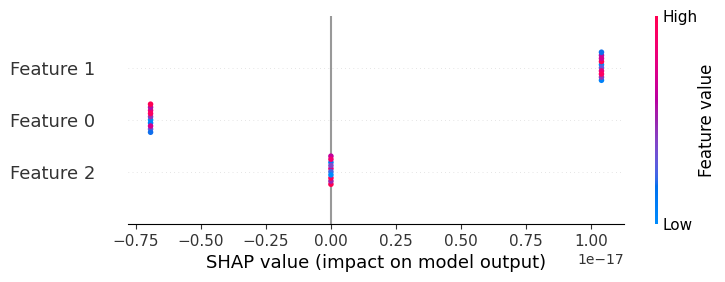

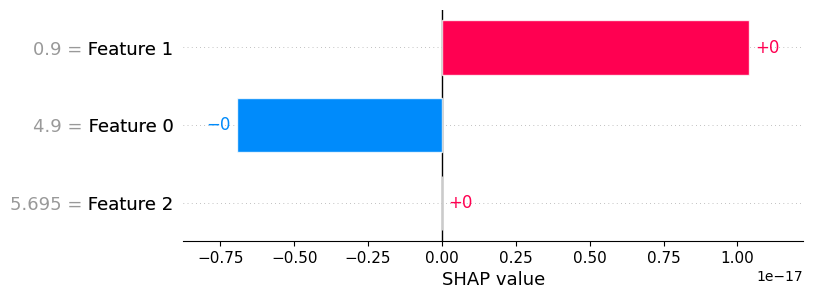

In [ ]:
explainer = shap.Explainer(predict_wrapper, states)
shap_values = explainer(states)

shap_values_price = shap_values[...,0]

shap.plots.beeswarm(shap_values_price)
shap.plots.bar(shap_values_price[0])

### Extract the top influential features

In [ ]:
data = {
    'ID': list(range(len(states))),
    'price': states[:,0],
    'discount': states[:,1],
    'sales': states[:,2],
    'top_feature1': [None] * len(states),
    'top_feature2': [None] * len(states),
    'importance1': [None] * len(states),
    'importance2': [None] * len(states)
}

features = ['price', 'discount', 'sales']

for i in range(len(states)):
    sorted_indices = np.argsort(-np.abs(shap_values.values[i][:,0]))
    data['top_feature1'][i] = features[sorted_indices[0]]
    data['importance1'][i] = shap_values.values[i][sorted_indices[0], 0]

    if len(sorted_indices) > 1:
        data['top_feature2'][i] = features[sorted_indices[1]]
        data['importance2'][i] = shap_values.values[i][sorted_indices[1], 0]

reason_df = pd.DataFrame(data)
print(reason_df.head(10))

   ID  price      discount  sales top_feature1 top_feature2   importance1  \
0   0    4.9  9.000000e-01  5.695     discount        price  1.040834e-17   
1   1    4.8  8.000000e-01  5.880     discount        price  1.040834e-17   
2   2    4.7  7.000000e-01  6.055     discount        price  1.040834e-17   
3   3    4.6  6.000000e-01  6.220     discount        price  1.040834e-17   
4   4    4.5  5.000000e-01  6.375     discount        price  1.040834e-17   
5   5    4.4  4.000000e-01  6.520     discount        price  1.040834e-17   
6   6    4.3  3.000000e-01  6.655     discount        price  1.040834e-17   
7   7    4.2  2.000000e-01  6.780     discount        price  1.040834e-17   
8   8    4.1  9.999999e-02  6.895     discount        price  1.040834e-17   
9   9    4.0 -1.490116e-08  7.000     discount        price  1.040834e-17   

    importance2  
0 -6.938894e-18  
1 -6.938894e-18  
2 -6.938894e-18  
3 -6.938894e-18  
4 -6.938894e-18  
5 -6.938894e-18  
6 -6.938894e-18  
7 -6.938

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
